# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 8
# Ensemble methods

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave


Import libraries:

In [2]:
import numpy as np
import pandas as pd
import itertools
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from scipy import stats
%matplotlib inline

# Higgs Boson Discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between a collision that produces Higgs bosons and collisions thats produce only background noise. We shall explore the use of ensemble methods for this classification task.

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle colision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background). 

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: <a href = "https://www.nature.com/articles/ncomms5308">Baldi et al., Nature Communications 5, 2014</a>.


## Question 1 (2pt): Single Decision Tree
We start by building a basic model which we will use as our base model for comparison. 

1. Fit a decision tree model to the training set and report the classification accuracy of the model on the test set. Use 5-fold cross-validation to choose the (maximum) depth for the tree. You will use the max_depth you find here throughout the homework. 


We read in the training and test sets first and examine the class distributions.

In [3]:
higgs_train = pd.read_csv('../hwassets/data/Higgs_train.csv')
higgs_train.columns = higgs_train.columns.str.strip()
higgs_test = pd.read_csv('../hwassets/data/Higgs_test.csv')
higgs_test.columns = higgs_test.columns.str.strip()
higgs_train.head()

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,...,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.376816,-1.583727,-1.707552,0.990897,0.114397,1.253553,0.619859,-1.479572,2.173076,0.753658,...,0.397156,0.000000,0.522449,1.318622,0.982398,1.359610,0.964809,1.309991,1.083203,1.0
1,0.707330,0.087603,-0.399742,0.918742,-1.229936,1.172847,-0.552574,0.886053,2.173076,1.298317,...,0.236231,0.000000,0.439696,0.828885,0.992241,1.157820,2.215780,1.189586,0.937976,1.0
2,0.617290,0.265839,-1.345227,1.154581,1.036646,0.954822,0.377252,-0.147960,0.000000,1.063507,...,-0.542413,0.000000,1.024506,1.026255,0.986289,0.927720,1.371080,0.981672,0.917436,1.0
3,0.850992,-0.380876,-0.071264,1.468704,-0.795133,0.691818,0.883260,0.496881,0.000000,1.616349,...,-1.520171,0.000000,1.197755,1.100534,0.987262,1.353453,1.455383,0.994682,0.953553,1.0
4,0.767540,-0.691572,-0.040191,0.614843,0.143765,0.748614,0.397057,-0.873640,0.000000,1.147862,...,0.502034,1.550981,0.921948,0.864080,0.982839,1.373222,0.601492,0.918621,0.957063,0.0


In [4]:
print(higgs_train['class'].sum() / higgs_train.shape[0])
higgs_test['class'].sum() / higgs_test.shape[0]

0.5246


0.5296

Roughly 52% of the particles detected in the training and test sets were Higgs bosons. Clearly, the classes have been balanced for machine learning!  OK so accuracy is a reasonable metric here. Now we will use 5-fold cross-validation to choose the (maximum) depth for the tree.

In [5]:
X_train = higgs_train.drop('class', axis=1)
X_test = higgs_test.drop('class', axis=1)
y_train = higgs_train['class']
y_test = higgs_test['class']

In [6]:
dt = tree.DecisionTreeClassifier()
gs_dt = GridSearchCV(dt, param_grid={'max_depth': list(range(1, 10))}, scoring='accuracy', cv=5, n_jobs=-1)
gs_dt.fit(X_train, y_train)
max_depth = gs_dt.best_estimator_.max_depth
max_depth

5

## Question 2 (15pt): Dropout-based Approach
We start with a simple method inspired from the idea of 'dropout' in machine learning, where we fit multiple decision trees on random subsets of predictors, and combine them through a majority vote. The procedure is described below.

- For each predictor in the training sample, set the predictor values to 0 with probability $p$  (i.e. drop the predictor by setting it to 0). Repeat this for $B$ trials to create $B$ separate training sets.


- Fit decision tree models $\hat{h}^1(x), \ldots, \hat{h}^B(x) \in \{0,1\}$ to the $B$ training sets. 

- Combine the decision tree models into a single classifier by taking a majority vote:
$$
\hat{H}_{maj}(x) \,=\, majority\Big(\hat{h}^1(x), \ldots, \hat{h}^B(x)\Big).
$$


We shall refer to the combined classifier as an ** *ensemble classifier* **. Implement the described dropout approach, and answer the following questions:
1. Apply the dropout procedure with $p = 0.5$ for different number of trees (say $2, 4, 8, 16, \ldots, 256$), and evaluate the training and test accuracy of the combined classifier. Does an increase in the number of trees improve the training and test performance? Explain your observations in terms of the bias-variance trade-off for the classifier.
- Fix the number of trees to 64 and apply the dropout procedure with different dropout rates $p = 0.1, 0.3, 0.5, 0.7, 0.9$. Based on your results, explain how the dropout rate influences the bias and variance of the combined classifier.
- Apply 5-fold cross-validation to choose the optimal combination of the dropout rate and number of trees. How does the test performance of an ensemble of trees fitted with the optimal dropout rate and number of trees compare with the single decision tree model in Question 1?
[hint: Training with large number of trees can take long time. You may need to restrict the max number of trees.]

Let's implement the dropout procedure as described above.

In [7]:
def dropout_function_forest(X_train, y_train, X_test, y_test, B, p, md=None):
    test_counts = np.zeros((y_test.shape[0], B))
    train_counts = np.zeros((y_train.shape[0], B))
    for i in range(B):
        train_set = X_train.copy()
        for column in X_train.columns:
            if np.random.uniform() < p:
                train_set[column] = 0
        test_counts[:, i] = (DecisionTreeClassifier(max_depth=md).fit(train_set, y_train)).predict(X_test)
        train_counts[:, i] = (DecisionTreeClassifier(max_depth=md).fit(train_set, y_train)).predict(X_train)
    y_hat = (np.mean(test_counts, axis=1) > .5).astype(float)
    y_hat_train = (np.mean(train_counts, axis=1) > .5).astype(float)
    return (metrics.accuracy_score(y_test, y_hat), metrics.accuracy_score(y_train, y_hat_train))

In [8]:
num_trees = [2**i for i in range(9)]
accuracies = []
for B in num_trees:
    accuracies.append(
        dropout_function_forest(X_train, y_train, X_test, y_test, B, 0.5, md=max_depth))

In [9]:
def plot_accuracies(xvar, xlabel, train_accuracies, test_accuracies, xlog=False):
    plt.plot(xvar, train_accuracies, label='train')
    plt.plot(xvar, test_accuracies, label='test')
    plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.legend();
    if xlog:
        plt.xscale('log')

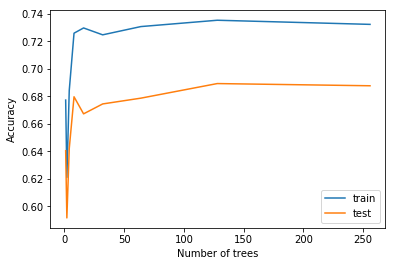

In [10]:
train_accuracies = [x[1] for x in accuracies]
test_accuracies = [x[0] for x in accuracies]
plot_accuracies(num_trees, 'Number of trees', train_accuracies, test_accuracies)

We can see that generally for a fixed maximum tree depth, that an increase in the number of trees corresponds to an increases in training and test accuracy. As more trees are added to the ensemble there is a decrease in bias.

Let's change the dropout rate for a fixed number of trees as described above.

In [11]:
ps = [((2 * i) + 1) / 10. for i in range(5)]
accuracies = []
for p in ps:
    accuracies.append(
        dropout_function_forest(X_train, y_train, X_test, y_test, 64, p, md=max_depth))

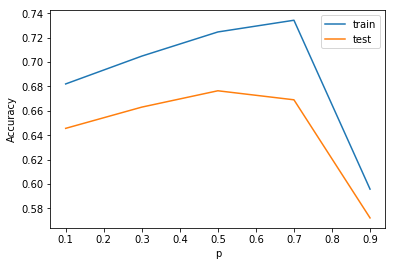

In [12]:
train_accuracies = [x[1] for x in accuracies]
test_accuracies = [x[0] for x in accuracies]
plot_accuracies(ps, 'p', train_accuracies, test_accuracies)

We can see that for a fixed number of trees, as we increase the p threshold, the training and test accuracies increases to a maximum and then decreases after this. corresponds to an increases in training and test accuracy. Basically we can see that we go from a high variance model (more complex) for low values of p to a high bias model (less complex) for high values of p. 

Now we will apply 5-fold cross-validation to choose the optimal combination of the dropout rate and number of trees.

In [13]:
accuracies = []
for B, p in itertools.product(num_trees, ps):
    point_accuracies = []
    kf = KFold(n_splits=5, random_state=102)
    for train, val in kf.split(X_train):
        point_accuracies.append(
            dropout_function_forest(X_train.loc[train, :], y_train[train], X_train.loc[val, :], y_train[val],
                                    B, p, md=max_depth))
    accuracies.append((B, p, np.mean(point_accuracies)))

In [14]:
max_accuracy = max(accuracies, key=lambda x: x[2])
best_num_tree = max_accuracy[0]
best_dropout = max_accuracy[1]
max_accuracy

(64, 0.5, 0.707625)

In [15]:
print('Test accuracy ensemble of trees: {0}'.format(
    dropout_function_forest(X_train, y_train, X_test, y_test, best_num_tree,
                            best_dropout, md=max_depth)[0]))
dt = tree.DecisionTreeClassifier(max_depth=max_depth)
dt.fit(X_train, y_train)
print('Test accuracy single tree: ', dt.score(X_test, y_test))

Test accuracy ensemble of trees: 0.6876
Test accuracy single tree:  0.6456


We can see that the test performance of an ensemble of trees fitted with the optimal dropout rate and number of trees is better compared with the single decision tree model in Question 1.

## Question 3 (15pt): Random Forests

We now move to a more sophisticated ensemble technique, namely random forest:
1. How does a random forest approach differ from the dropout procedure described in Question 2? 
 
- Fit random forest models to the training set for different number of trees (say $2, 4, 8, 16, \ldots, 256$), and evaluate the training and test accuracies of the models. You may set the number of predictors for each tree in the random forest model to $\sqrt{p}$, where $p$ is the total number of predictors. 

- Based on your results, do you find that a larger number of trees necessarily improves the test accuracy of a random forest model? Explain how the number of trees effects the training and test accuracy of a random forest classifier, and how this relates to the bias-variance trade-off for the classifier. 
  
- Fixing the number of trees to a reasonable value, apply 5-fold cross-validation to choose the optimal value for the  number of predictors. How does the test performance of random forest model fitted with the optimal number of trees compare with the dropout approach in Question 2?  





The random forest approach differs from the dropout procedure described in Question 2. For the dropout procedure, each decision tree sees training data consisting of a random subset of the predictors according to the fraction p. That is the predictors may be different for each decision tree, however, the predictors are fixed for every split of the decision tree. However, in the random forest approach, although the number of preditors is fixed, a different subset of predictors is selected at random for each split in the different decision trees. So effectively, every tree in the random forest sees more variation in the data when compared with the dropout procedure.

Let's now fit random forest models to the training set as described above and look at how the training and test error varies with the number of trees.

In [16]:
train_accuracies = []
test_accuracies = []
for n in num_trees:
    rf = RandomForestClassifier(n_estimators=n, max_features='sqrt')
    rf.fit(X_train, y_train)
    train_accuracies.append(rf.score(X_train, y_train))
    test_accuracies.append(rf.score(X_test, y_test))

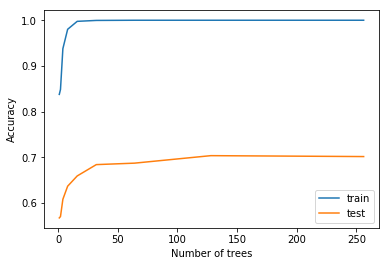

In [17]:
plot_accuracies(num_trees, 'Number of trees', train_accuracies, test_accuracies)

Based on the results, a larger number of trees does not necessarily improve the test accuracy of a random forest model. Increasing, the number of trees increases the training accuracy of a random forest classifier. In fact we see that we are overfitting as the models are achieving perfect accuracy on the training set and the test accuracy is much lower. The model is not generalizing well as we make it more complex (add more trees to the ensemble) and trade bias for variance.

Let's fix the number of trees to a reasonable value and apply 5-fold cross-validation to choose the optimal value for the number of predictors.

In [18]:
rf = RandomForestClassifier(n_estimators=64)
gs_rf = GridSearchCV(rf, param_grid={'max_features': list(range(2, 20, 2))}, scoring='accuracy', cv=5, n_jobs=-1)
gs_rf.fit(X_train, y_train)
max_features = gs_rf.best_estimator_.max_features
max_features

6

In [19]:
rf = RandomForestClassifier(n_estimators=64, max_features=max_features)
rf.fit(X_train, y_train)
print('Test accuracy random forest:', rf.score(X_test, y_test))

Test accuracy random forest: 0.691


We see that as expected, the test performance of random forest model fitted with the optimal number of trees is higher compared with the dropout approach in Question 2.  

## Question 4 (15pt): Boosting

We next compare the random forest model with the approach of boosting:


1. Apply the AdaBoost algorithm to fit an ensemble of decision trees. Set the learning rate to 0.05, and try out different tree depths for the base learners: 1, 2, 10, and unrestricted depth.  Make a plot of the training accuracy of the ensemble classifier as a function of tree depths. Make a similar plot of the test accuracies as a function of number of trees (say $2, 4, 8, 16, \ldots, 256$).
- How does the number of trees influence the training and test performance? Compare and contrast between the trends you see in the training and test performance of AdaBoost and that of the random forest models in Question 3. Give an explanation for your observations.
- How does the tree depth of the base learner impact the training and test performance? Recall that with random forests, we allow the depth of the individual trees to be unrestricted. Would you recommend the same strategy for boosting? Explain your answer.
- Apply 5-fold cross-validation to choose the optimal number of trees $B$ for the ensemble and the optimal tree depth for the base learners. How does an ensemble classifier fitted with the optimal number of trees and the optimal tree depth compare with the random forest model fitted in Question 3.4? 



Let's apply the AdaBoost algorithm to fit an ensemble of decision trees and look how the training and test accuracy varies as a function of tree depths and also as a function of the number of trees.

In [20]:
train_accuracies = []
test_accuracies = []
max_depths = [1, 2, 10, None]
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, random_state=101)
    ada = AdaBoostClassifier(base_estimator=rf, learning_rate=0.05, random_state=105)
    ada.fit(X_train, y_train)
    train_accuracies.append(ada.score(X_train, y_train))
    test_accuracies.append(ada.score(X_test, y_test))

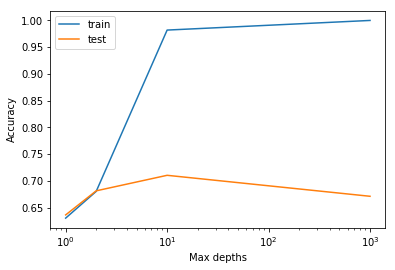

In [21]:
max_depths[3] = 1e3 #set to large arbitrary number for graph
plot_accuracies(max_depths, 'Max depths', train_accuracies, test_accuracies, xlog=True)

In [22]:
train_accuracies = []
test_accuracies = []
for n in num_trees:
    rf = RandomForestClassifier(n_estimators=n, random_state=101)
    ada = AdaBoostClassifier(base_estimator=rf, learning_rate=0.05, random_state=105)
    ada.fit(X_train, y_train)
    train_accuracies.append(ada.score(X_train, y_train))
    test_accuracies.append(ada.score(X_test, y_test))

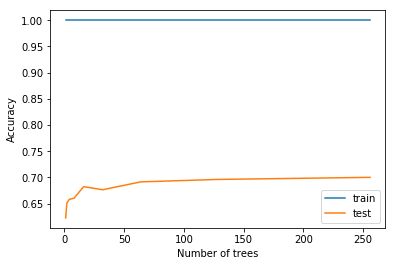

In [23]:
plot_accuracies(num_trees, 'Number of trees', train_accuracies, test_accuracies)

We can see for the AdaBoost model that as the number of trees increases so does the training and test performance. This is similar to the trends we see in the training and test performance of the random forest models in Question 3. Basically as we increase the complexity of the model by adding more trees (iterations) we are able to reduce the bias in our model.

We see that as the tree depth of the based learner increases, we fit better to the training data and in fact fit it perfectly when we do not restrict the depth of the tree. However, for the test set the performance increases to an optimum value and then decreases as we start to overfit. This is why for boosting we must restrict the maximum depth of the tree. This is different for random forests  where we allow the depth of the individual trees to be unrestricted.

Let's now apply 5-fold cross-validation to choose the optimal number of trees $B$ for the ensemble and the optimal tree depth for the base learners.

In [24]:
num_trees = [2**i for i in range(5, 8)]
max_depths = [5, 10, 15, 20]
x_val_scores = []
for n, max_depth in itertools.product(num_trees, max_depths):
    point_accuracies = []
    ada = AdaBoostClassifier(RandomForestClassifier(n_estimators=n, max_depth=max_depth, n_jobs=-1),
                                 learning_rate=0.05, random_state=155)
    x_val_scores.append((n, max_depth, np.mean(
        cross_val_score(ada, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1))))

In [25]:
max_x_val_score = max(x_val_scores, key=lambda x: x[2])
best_num_tree = max_x_val_score[0]
best_tree_depth = max_x_val_score[1]
max_x_val_score

(128, 10, 0.7004041632041632)

We see that the ensemble classifier (AdaBoost) fitted with the optimal number of trees and the optimal tree depth has a higher classification accuracy on the test set than the random forest model fitted in Question 3.4.

## Question 5 (3pt): Meta-classifier

We have so far explored techniques that grow a collection of trees either by creating multiple copies of the original training set, or through a sequential procedure, and then combines these trees into a single classifier. Consider an alternate scenario where you are provided with a pre-trained collection of trees, say from different participants of a data science competition for Higgs boson discovery. What would be a good strategy to combine these pre-fitted trees into a single powerful classifier? Of course, a simple approach would be to take the majority vote from the individual trees. Can we do better than this simple combination strategy?

A collection of 100 decision tree classifiers is provided in the file `models.npy` and can be loaded into an array by executing:

`models = np.load('models.npy')`

You can make predictions using the $i^\text{th}$ model on an array of predictors `x` by executing:

`model[i].predict(x)`  &nbsp;&nbsp;&nbsp;
or &nbsp;&nbsp;&nbsp;
`model[i].predict_proba(x)`

and score the model on predictors `x` and labels `y` by using:

`model[i].score(x, y)`.

1. Implement a strategy to combine the provided decision tree classifiers, and compare the test perfomance of your approach with the majority vote classifier. Explain your strategy/algorithm.



Let's load in the decision tree classifiers.

In [26]:
models = np.load('../hwassets/data/models.npy', encoding='latin1')
len(models)

C:\Users\covuworie\.virtualenvs\a-2017-AsNAB769\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.18.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


100

Let's look at the test performance of the majority vote classifier.

In [27]:
def majority_vote_accuracy(clfs, X, y):
    clf_predicts = predictions(clfs, X, y)
    meta_predicts = stats.mode(clf_predicts, axis=1)[0]
    accuracy = metrics.accuracy_score(y, meta_predicts)
    return accuracy

def predictions(clfs, X, y):
    predicts = np.empty(shape=(y.shape[0], clfs.shape[0]), dtype=float)
    for i, clf in enumerate(clfs):    
        predicts[:, i] = clf.predict(X)
    return predicts

In [28]:
print('Test accuracy majority vote classifier:',
      majority_vote_accuracy(models, X_test, y_test.values.reshape(-1, 1)))

Test accuracy majority vote classifier: 0.6646


Let's now implement a meta-classifier. The strategy is to use the predictions of the individual decision tree models as input features to a meta-classifier. This meta-classifier will then make predictions on these inputs.

In [29]:
def meta_classifier_accuracy(meta_clf, clfs, X, y):
    X_predicts = predictions(clfs, X, y)
    meta_clf.fit(X_predicts, y)
    accuracy = meta_clf.score(X_predicts, y)
    return accuracy

In [30]:
print('Test accuracy majority vote classifier:',
      meta_classifier_accuracy(LogisticRegressionCV(cv=5, scoring='accuracy', random_state=133),
                               models, X_test, y_test.values))

Test accuracy majority vote classifier: 0.6994


Notice that we chose a logistic regression classifier as our meta-classier, but we could have chosen any other classifier. We see that the performance accuracy on test set is better than the majority vote classifier. However, note that we have cheated here! The problem is that each individual decision tree model was trained on all the training data. Really the meta classifier should be built by making predictions on a held out a set of data as described in the lectures.

--- 

---

## APCOMP209a - Homework Question
​
We've worked with imputation methods on missing data in Homework 6.  We've worked with Decision Trees in HW7 and here.  Now let's see what happens if we try to work with Decision Trees and Missing Data at the same time! We'll be working with a dataset from the UCI Machine Learning Repository that uses a variety of wine chemical predictors to classify wines grown in the same region in Italy.  Each line represents 13 (mostly chemical) predictors of the response variable wine class, including things like alcohol content, hue , and phenols.  Unfortunately some of the predictor values were lost in measurement. Please load `wine_quality_missing.csv`. 
​
*Note*: As in HW6 be careful of reading/treating column names and row names in this data set.
​
​
1. Remove all observations that contain and missing values, split the dataset into a 75-25 train-test split, and fit the sklearn DecisionTreeClassifier and RandomForestClassifier.   Use cross-validation to find the optimal tree depth for each method.  Report the optimal tree-depth, overall classification rate and confusion matrix on the test set for each method.
2. Restart with a fresh copy of the data and impute the missing data via mean imputation.  Split the data 75-25 and again fit DecisionTreeClassifier and RandomForestClassifier using cross-validation to find the optimal tree depth.  Report the optimal tree depth, overall classification rate and confusion matrix on the test set for each method.  
3. Again restart with a fresh copy of the data but this time let's try something different.  As discussed in section, CART Decision Trees can take advantage of surrogate splits to handle missing data.  Split the data 75-25 and construct a **custom** decision tree model and train it on the training set with missing data. Report the optimal tree depth, overall classification rate and confusion matrix on the test set and compare your results to the Imputation and DecisionTree model results in part 1 & 2.


We read in the data.

In [31]:
wine_quality_missing = pd.read_csv('../hwassets/data/wine_quality_missing.csv')
wine_quality_missing.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,Class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,1
1,13.20,1.78,2.14,NaN,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,1
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,1
3,14.37,1.95,2.50,NaN,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,1
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,NaN,4.32,1.04,2.93,735.0,1


Let's drop the missing values and split the training and test data into a 75-25 split.

In [32]:
wine_quality = wine_quality_missing.dropna()
X_train, X_test, y_train, y_test = train_test_split(
    wine_quality.drop('Class', axis=1), wine_quality.Class, test_size=0.25, random_state=42)

Now we use cross-validation to find the optimal tree depth for a single Decision Tree and for a Random Forest and report the optimal tree-depth, overall classification rate and confusion matrix on the test set for each method.

In [33]:
def grid_search_tree_depth(clf, X_train, y_train, max_depths, cv=5, scoring='accuracy'):
    gs = GridSearchCV(clf, param_grid={'max_depth': max_depths}, scoring=scoring, cv=cv)
    gs.fit(X_train, y_train)
    max_depth = gs.best_estimator_.max_depth
    return max_depth

def print_depth_acc_conf(clf, X_train, y_train, X_test, y_test, random_state=None):
    max_depth = grid_search_tree_depth(clf, X_train, y_train, max_depths=list(range(1, 10)))
    clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Max depth: {0}, Test accuracy: {1}'.format(max_depth, np.round(clf.score(X_test, y_test), 2)))
    print(metrics.confusion_matrix(y_test, y_pred))

In [34]:
print_depth_acc_conf(tree.DecisionTreeClassifier(), X_train, y_train, X_test, y_test, random_state=55)

Max depth: 2, Test accuracy: 0.64
[[3 2 0]
 [0 2 0]
 [0 2 2]]


In [35]:
print_depth_acc_conf(RandomForestClassifier(), X_train, y_train, X_test, y_test, random_state=44)

Max depth: 6, Test accuracy: 0.82
[[3 2 0]
 [0 2 0]
 [0 0 4]]


Let's now impute the missing values using mean imputation and repeat the analysis.

In [36]:
mean_imputer = Imputer(strategy='mean')
wine_quality = pd.DataFrame(data=mean_imputer.fit_transform(wine_quality_missing),
                            columns=wine_quality.columns)
wine_quality.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,Class
0,14.23,1.71,2.43,15.600000,127.0,2.80,3.06,0.28,2.290000,5.64,1.04,3.92,1065.0,1.0
1,13.20,1.78,2.14,19.508861,100.0,2.65,2.76,0.26,1.280000,4.38,1.05,3.40,1050.0,1.0
2,13.16,2.36,2.67,18.600000,101.0,2.80,3.24,0.30,2.810000,5.68,1.03,3.17,1185.0,1.0
3,14.37,1.95,2.50,19.508861,113.0,3.85,3.49,0.24,2.180000,7.80,0.86,3.45,1480.0,1.0
4,13.24,2.59,2.87,21.000000,118.0,2.80,2.69,0.39,1.596211,4.32,1.04,2.93,735.0,1.0


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    wine_quality.drop('Class', axis=1), wine_quality.Class, test_size=0.25, random_state=42)

In [38]:
print_depth_acc_conf(tree.DecisionTreeClassifier(), X_train, y_train, X_test, y_test, random_state=55)

Max depth: 4, Test accuracy: 0.96
[[15  0  0]
 [ 0 18  0]
 [ 1  1 10]]


In [39]:
print_depth_acc_conf(RandomForestClassifier(), X_train, y_train, X_test, y_test, random_state=44)

Max depth: 9, Test accuracy: 0.98
[[15  0  0]
 [ 0 18  0]
 [ 0  1 11]]


Apparently CART Decision Trees to take advantage of surrogate splits to handle missing data. This is [not currently implemented in sklearn](https://stats.stackexchange.com/questions/230638/handling-missing-values-for-decision-tree). Option 4 is the one referred to here and is apparently implemented in [rpart](https://cran.r-project.org/web/packages/rpart/index.html) in R. Apparently it is computationally expensive and the [slight improvements in predictive power may not outweigh the computational cost](https://stats.stackexchange.com/questions/230638/handling-missing-values-for-decision-tree).